# Probability Ninjas - Assignment 4
* Vipul Popat
* Saurabh Goel
* Vijay Sambhe
* Mark O'Brien
* Mike Nolan

## Description

Sales forecasting techniques allow companies to predict sales, and once a company has what it believes is an accurate estimate of future sales it can then quantify finance needs, estimate the quantity and cost of purchases of raw materials as well as determining production level.

A fundamental problem in sales forecasting is predicting if sales will increase or not. This is particularly difficult in case the sales of a given product exhibits seasonality. In time series data, seasonality is the presence of variations that occur at specific regular intervals and repeats regularly.
For example, the sales of ice cream will be higher in the warmer seasons and lower in the colder seasons.

The provided dataset contains past sales of a **multinational ice-cream** company that sells ice-creams in 120 different Countries. Each row in the dataset is a time-series: the input x is time (scaled and transformed in the interval [0,1]) and the output y represents the sales in one of the Country (this was also scaled and transformed). There are 120 rows (Countries).

#### Goal

Construct an algorithm that, for each Country:

1. removes the seasonal component in the time-series (if a seasonal component is present);
2. predicts if the non-seasonal component of sales is increasing or not. That is the prediction is binary: value=1 if the non-seasonal component is increasing; value=0 if the non-seasonal component is not increasing.

#### Remarks

1. Some time-series may not have a seasonal component. At low latitudes, there is not significant seasonal change.
2. The original time-series duration is unknown. Time is assumed to be normalised into the interval [0,1] (100 evenly spaced numbers in the interval [0,1])

## Evaluation

Submissions will be evaluated based on *Weighted accuracy*:

$$
WA = \frac{\sum_{i=1}^{n}\omega_{i} (y_i==\hat{y}_i)}{\sum_{i=1}^{n}\omega_{i}}
$$

where

$$
\begin{array}{ll}
\omega_i = 6 & \text{if } y_i=\hat{y}_i \text{ and } y_i=0 \\
\omega_i = 4 & \text{if } y_i=\hat{y}_i \text{ and } y_i=1 \\
\end{array}
$$

Note that, for the ice-cream company, predicting $0$ is more important than predicting $1$.

### Submission Format

The submission file should be in text format (.csv). The submission file must have the following format:

$$
\begin{array}{cc}
Id & Category\\
0 & 1\\
1 & 0\\
2 & 1\\
3 & 1\\
4 & 0\\
... & ...\\
\end{array}
$$

where _Id_ is the Id of the time-series (the first column of the dataset) and Category is your prediction for that time-series. Note again that the prediction is binary: value=1 if the non-seasonal component of the time-series is increasing; value=0 if the non-seasonal component is not increasing. Be sure that the values in the Id and Category column are integers (not float).

#### Imports

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy.stats import multivariate_normal
from statsmodels.tsa.seasonal import seasonal_decompose
import GPy as GPy
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

## Load Data / Data Exploration

### Training Data

Here we load the `train.csv` dataset and take a look at the data contained in it.

In [2]:
train_df = pd.read_csv('./data/train.csv')
print(f'Shape: {train_df.shape}')
train_df.describe()

Shape: (75, 102)


,Id,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,Category
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,...,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,157.000000,0.140018,0.116428,0.147523,0.166251,0.159290,0.154911,0.171788,0.163420,0.172034,...,0.563733,0.576017,0.572355,0.580488,0.599886,0.639733,0.631687,0.633445,0.670396,0.346667
std,21.794495,0.531072,0.533557,0.515018,0.513822,0.506893,0.501646,0.484376,0.499714,0.497433,...,0.742961,0.740551,0.764901,0.733439,0.786804,0.754772,0.783581,0.783238,0.775564,0.479113
min,120.000000,-1.044003,-0.994305,-0.885585,-0.761513,-0.717464,-0.757696,-0.578701,-0.647595,-0.474244,...,-0.218118,-0.130778,-0.242646,-0.238697,-0.183577,-0.199834,-0.194937,-0.300764,-0.150227,0.000000
25%,138.500000,-0.102221,-0.094447,-0.071158,-0.059394,-0.101118,-0.092047,-0.081801,-0.059817,-0.075092,...,0.027346,0.048706,0.028304,0.036863,0.017775,0.057197,0.025564,0.066313,0.064214,0.000000
50%,157.000000,0.051074,0.038222,0.050688,0.068801,0.057736,0.024308,0.044768,0.015566,0.001266,...,0.231157,0.202431,0.208260,0.193447,0.213291,0.220146,0.176925,0.207900,0.247912,0.000000
75%,175.500000,0.244199,0.212144,0.250240,0.215488,0.184486,0.189067,0.149534,0.138871,0.132242,...,0.790795,0.870270,0.924093,0.946616,1.148687,1.114469,1.114301,1.151813,1.212613,1.000000
max,194.000000,1.159202,1.139233,1.249389,1.217042,1.243997,1.208698,1.294389,1.222726,1.351073,...,2.098946,2.051068,2.155725,2.075734,2.084094,2.101399,2.219500,2.115519,2.118771,1.000000


In [3]:
train_df.head(10)

,Id,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,Category
0,120,0.147298,-0.142030,0.091737,-0.151707,0.060124,0.186191,-0.021298,-0.025636,0.061044,...,-0.218118,0.011316,0.079464,-0.010833,-0.053485,0.046450,-0.008333,0.168574,0.123273,0
1,121,0.115710,0.105061,0.038446,0.166711,-0.113913,0.004528,-0.006954,-0.140054,0.154231,...,0.021526,0.069009,-0.060343,0.094007,0.049558,0.112370,0.020398,0.039687,0.217384,0
2,122,-0.548826,-0.466551,-0.650890,-0.553450,-0.449101,-0.496902,-0.464860,-0.394458,-0.271801,...,0.057272,0.088062,-0.069730,0.168498,0.109672,0.202808,-0.019942,0.058902,0.053936,0
3,123,0.192618,0.291155,-0.042980,0.146483,0.015390,0.019394,-0.005577,-0.048682,0.025772,...,0.140831,0.257332,0.262786,0.351659,0.213291,0.251077,0.190920,0.251743,0.337730,1
4,124,0.075706,0.069045,-0.019818,0.068801,-0.226501,0.011658,0.087905,-0.080787,-0.080369,...,0.434803,0.322841,0.297772,0.461421,0.406143,0.562082,0.554588,0.471489,0.384229,1
5,125,1.081769,0.986722,1.067524,1.140523,0.975286,1.074729,0.871820,1.140957,1.276274,...,2.098946,1.882913,1.979897,1.852567,2.043995,2.059601,2.219500,2.038103,2.072409,1
6,126,0.212677,0.271821,0.052499,0.353935,0.177247,0.165208,0.077037,0.054077,0.001218,...,0.880501,0.894316,0.776692,0.910526,1.145064,1.302965,1.182394,1.286594,1.184424,1
7,127,-1.044003,-0.994305,-0.885585,-0.678902,-0.717464,-0.513387,-0.501884,-0.647595,-0.336069,...,0.607999,0.508485,0.442513,0.644257,0.838618,0.936488,0.929766,0.965134,1.024578,1
8,128,0.984083,0.938459,0.956299,0.922269,1.078399,1.107597,0.983515,1.222726,1.049279,...,1.937170,1.951902,2.069157,2.075734,1.953834,1.922141,1.913410,1.965790,1.956595,0
9,129,-0.056781,0.053274,0.033048,0.010449,0.101132,-0.055987,-0.045404,0.012941,-0.047868,...,0.231157,0.182868,0.240331,0.156288,0.218797,0.042883,0.127180,0.130278,0.162561,0


Next we can plot all sales data for every Country.

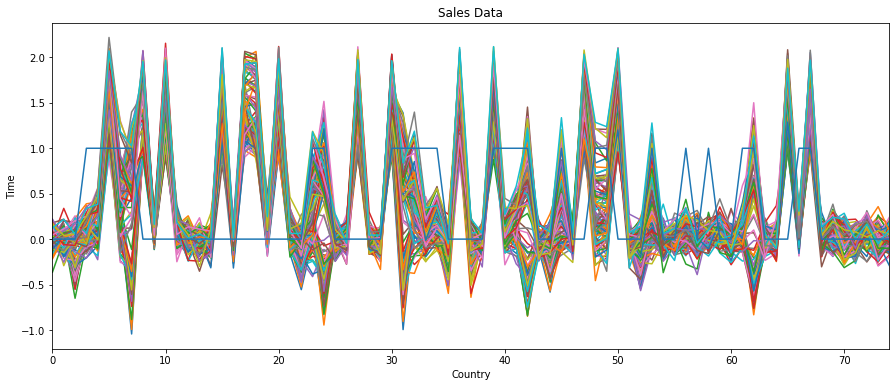

In [4]:
def plot_dataset(dataset):
    ax = dataset.loc[:, dataset.columns != 'Id'].plot(figsize = (15,6), title="Sales Data", legend = False)
    ax.set(xlabel="Country", ylabel="Time")
    plt.show()

plot_dataset(train_df)

### Test Data

Similarly, we will now load the `test.csv` dataset and take a look at the data contained in it.

In [5]:
test_df = pd.read_csv('./data/test.csv')
print(f'Shape: {test_df.shape}')
test_df.head()

Shape: (120, 101)


,Id,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,0,1.050702,1.004361,0.880657,0.959512,1.014129,0.890916,0.986703,1.135940,1.223539,...,1.826883,1.797263,1.872348,1.926992,1.843073,1.958611,1.800846,1.867793,2.056990,2.060379
1,1,-0.042360,-0.134542,-0.093373,0.076402,-0.122659,-0.149690,-0.050888,0.087327,-0.003546,...,0.233283,0.265816,0.218283,0.134600,0.273861,0.056165,0.103871,0.099539,0.305985,0.294278
2,2,0.035063,0.050938,0.067512,0.117029,0.049060,-0.014029,0.079372,0.204120,0.002883,...,-0.005722,0.195326,0.169835,0.255006,0.211215,0.116720,0.162032,0.116356,0.305580,0.202131
3,3,-0.111408,-0.063093,-0.094206,-0.054800,-0.021415,0.083715,-0.032116,-0.158563,0.114007,...,0.074536,0.009352,-0.016270,-0.087119,0.007215,0.073824,-0.114334,0.008747,0.023304,-0.071806
4,4,0.977574,0.989015,1.243740,1.111227,1.288457,1.000790,1.052081,0.937450,0.999783,...,1.907418,1.892012,1.780125,1.899383,1.939521,1.896775,2.038367,2.071734,1.982058,2.023052


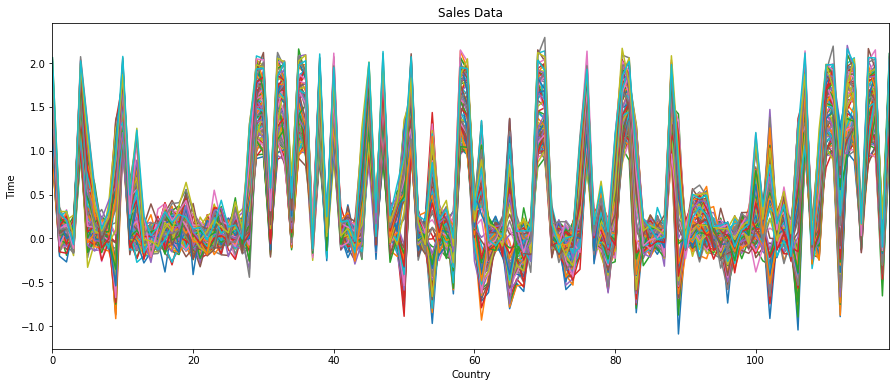

In [6]:
plot_dataset(test_df)

## Visual Analysis
#### What we can see here is that the trends differ quite a bit between the training and test sets. We would expect our probabilistic model to be able to handle this case. 

# Data Analysis - Seasonality
The dataset provided deals with sales data over a period of time. As such we will first inspect that data to see if what we are seeing is the sales trend alone or if it includes a seasonal component. This is important to ensure our predictions are based on the trend and not seasonality. 

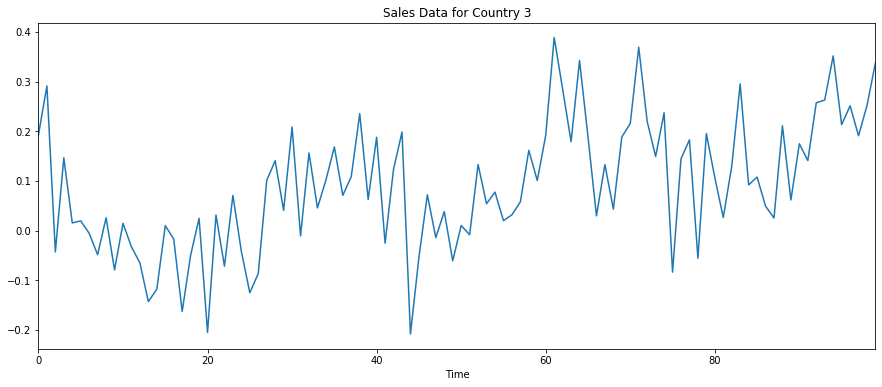

In [78]:
periodic_freq = 12
country_id = 3

ax = train_df.iloc[country_id,1:101].plot(figsize = (15,6), title=f"Sales Data for Country {country_id}", legend = False)
ax.set(xlabel="Time")
plt.show()

The above plot shows the sales data, unaltered for a single country. We can observe an upward trend over time. The shape of the data may indicate a periodic component. The following sections aim to discover if that is the case. 

## Looking for Trends
In looking for trends in the data we plotted the rolling mean across all countries sales data, the following was produced

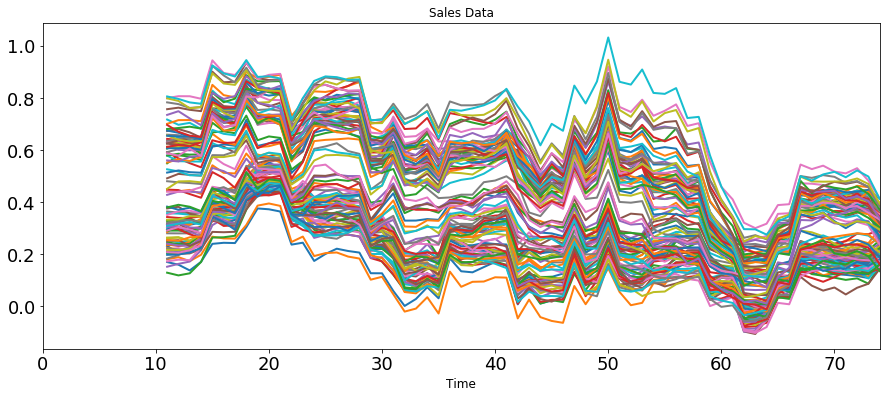

In [79]:
sales_all = train_df.iloc[:,1:101]
sales_all.rolling(periodic_freq).mean().plot(figsize = (15,6), title="Sales Data", linewidth=2, fontsize=18, legend = False)
plt.xlabel('Time', fontsize=12);
plt.show()

What the above shows us is that there is a common pattern among all countries. Unfortunately it does not show a smooth trend for them as a whole. This lead us to think about whether or not each country does have a seasonal trend?

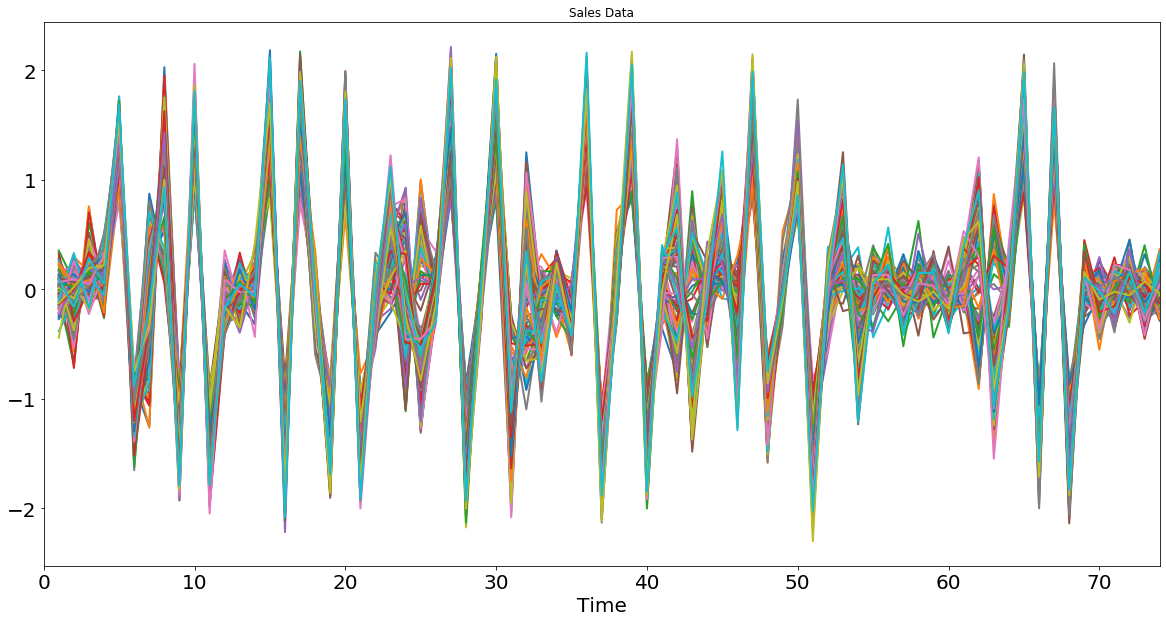

In [70]:
sales_all.diff().plot(figsize=(20,10), title="Sales Data", linewidth=2, fontsize=20, legend=False)
plt.xlabel('Time', fontsize=20);

By removing the trend from the data we can see a very clear pattern of highs and lows. There appears to be some very obvious spikes but they don't follow any particular trend or pattern. This further lead us to believe that periodicity was not uniform across all countries. 

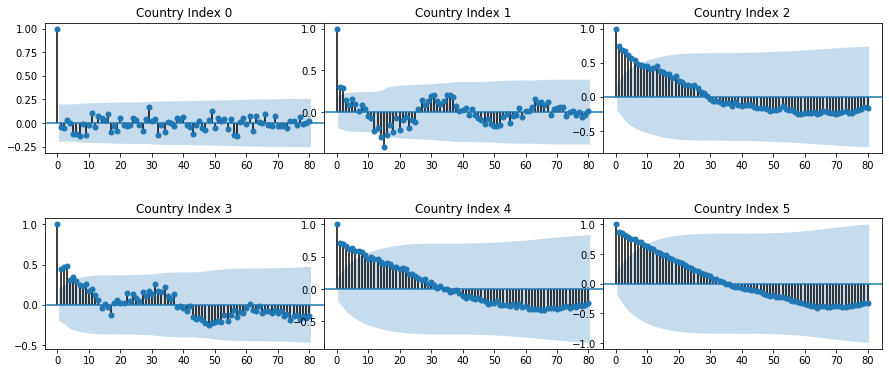

In [88]:
fig, axs = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(6):
    plot_acf(sales_all.iloc[i, 1:101], lags=80, title=f'Country Index {i}', ax=axs[i])

plt.show()

Auto correlation plot look for randomness in the data. This is done by computing autocorrelations for data values at varying time lags. The shaded area indicate 95% confidence. 

What we found interesting was that some countries did not have a clear repeating correlation whereas other did. This furthered our thinking around seasonality varying country by country. 

# Stationary Time Series
From the data it would appear that in some countries there are seasonal components. We looked at a method called differing to see if we could make each time series stationary. 

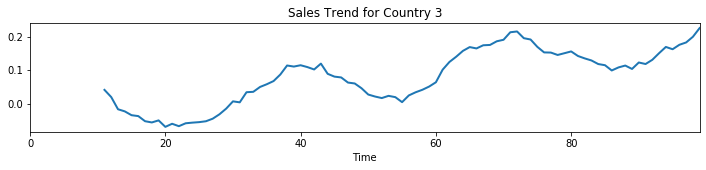

In [112]:
sales = train_df.iloc[country_id,1:101]
trend = sales.rolling(periodic_freq).mean()
trend.plot(figsize = (12,2), title=f"Sales Trend for Country {country_id}", linewidth=2, legend = False)
plt.xlabel('Time');
plt.show()

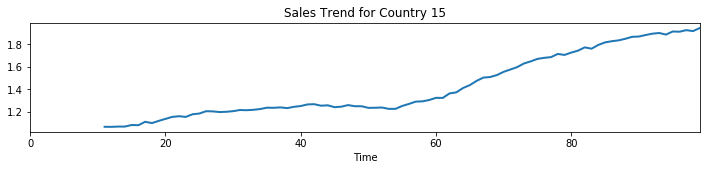

In [113]:
sales2 = train_df.iloc[15,1:101]
trend2 = sales2.rolling(periodic_freq).mean()
trend2.plot(figsize = (12,2), title=f"Sales Trend for Country {15}", linewidth=2, legend = False)
plt.xlabel('Time');
plt.show()

The two example above show the output of calculating the rolling mean across each time series. In the first example we see an obvious pattern emerge. With the second we see and more linear output. 

What we believe this tells us is that this method can be utilized to detect periodic trends in the data.

Rather than calculating the trend manually we looked into libraries that may assist us. seasonal_decompose was one such method. We can see, in comparison, that the trends match up. 

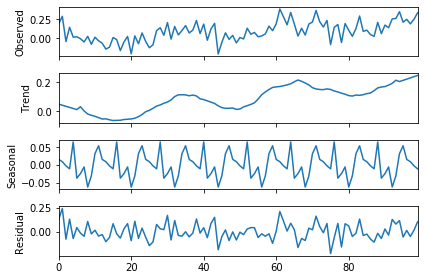

In [115]:
decomp_single = seasonal_decompose(train_df.iloc[country_id,1:101].T, model='additive', freq=periodic_freq, extrapolate_trend='freq')
decomp_single.plot()
plt.show()

From this plot we can see a couple of interesting elements: 
* Observed - This shows us the values observed for this country over time, unaltered
* Trend - We can conclude from above that this view is also generated using a rolling mean
* Seasonal - The interesting point here is the very small range that the seasonality covers, only +- 0.025
* Residual - Follows a similar pattern to the difference plot which we used to see a periodic pattern in the data

We chose to highlight this example as it seems to contain a periodic trend even after differing using the mean. 

# Data Modeling 
With a better understanding of our data we moved on to modeling. 

## Basis Functions

Here first we will try to utilize Basis functions, we also tried to implement tanh for the non linear component.

In [118]:
#tanh is applied to get basis component for the non linear component, but only make_basis_linear_periodic_tanh 
#function below is used.

#Infer weight from data
def getw(x, y):
  X_pseudo_inverse = np.dot(np.linalg.inv(np.dot(x.T,x)), x.T)
  w_in = np.dot(X_pseudo_inverse, y)
  return w_in

#Function with periodic and nonlinear only
def make_basis_periodic_tanh(x,y):
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    w0 = np.ones((x.shape[0],1))
    tanh_calculated = np.tanh(w0 + x*getw(x,y))
    return np.hstack([np.ones((x.shape[0],1)),periodic, tanh_calculated]) 

#Function with nonlinear only
def make_basis_tanh(x,y):
    
    w0 = np.ones((x.shape[0],1))
    tanh_calculated = np.tanh(w0 + x*getw(x,y))
    return np.hstack([np.ones((x.shape[0],1)), tanh_calculated]) 

#Function with linear and nonlinear only
def make_basis_linear_tanh(x,y):
    
    w0 = np.ones((x.shape[0],1))
    tanh_calculated = np.tanh(w0 + x*getw(x,y))
    return np.hstack([np.ones((x.shape[0],1)),x, tanh_calculated]) 

#Function with linear, periodic and nonlinear only
def make_basis_linear_periodic_tanh(x,y):
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    w0 = np.ones((x.shape[0],1))
    tanh_calculated = np.tanh(w0 + x*getw(x,y))
    return np.hstack([np.ones((x.shape[0],1)),x, periodic, tanh_calculated]) 

#test function
def test(x,y,plot=False):   
  H = make_basis_tanh(x.reshape(-1,1), y)
  return H



In [119]:
#Original basis functions
def make_basis(x):
 
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    return np.hstack([np.ones((x.shape[0],1)),x, periodic ]) 


### Function to Attempt Use of Tanh (Non Linearity)
In this function the approach is tried where it checks if the sample lines (straight ones) cross the mean function, if just once or below then it is considered linear function

In [120]:
col_per = 2

#In this function the approach is tried where it checks if the sample lines (straight ones) cross the 
#mean function, if just once or below then it is considered linear function
def run_model(x,y,functype, plot=False): 
    #Call basis function for various functype variable value. But this function is always called with value 0
    if (functype ==0):
      H = make_basis(x.reshape(-1,1))
    elif (functype ==1):
      H = make_basis_linear_periodic_tanh(x.reshape(-1,1),y)
    elif (functype ==2):
      H = make_basis_linear_tanh(x.reshape(-1,1),y)
    elif (functype ==3):
      H = make_basis_tanh(x.reshape(-1,1),y)
    elif (functype ==4):
      H = make_basis_periodic_tanh(x.reshape(-1,1),y)
      
    #normalize the data
    yn = (y-np.mean(y))/np.std(y)
    
    #select non periodic components of the basis
    H_np = H[:,0:col_per]
    

    with pm.Model() as model:
        #prior
        w = pm.Normal('weights', mu=0, sd=50, shape=(H.shape[1],))
        sigma = pm.HalfCauchy('sigma', 5)

        #linear model
        mu = pm.Deterministic('mu', pm.math.matrix_dot(H,w).T)

        #likelihood
        y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=yn)

        #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)
        
    posterior = approx.sample(draws=500)
    
    #could the strength of these be deciding factor which one to go for?
    #note the peridic basis also works with non linear, so its misleading
    
    print(np.mean(posterior['weights'],axis=0))
    v=posterior
    all_prediction = np.dot(H,posterior['weights'].T).T
    
    non_periodic_prediction = np.dot(H_np,posterior['weights'][:,0:col_per].T).T
    
    
    if plot==True:
        plt.figure(figsize=(10,8))
        #plt.plot(x,all_prediction[0:100,:].T,'r', alpha=0.05)
        plt.plot(x,non_periodic_prediction[0:100,:].T,'b', alpha=0.05)
        plt.plot(x,np.mean(all_prediction,axis=0),'r', label='Overall Mean')
        plt.plot(x,np.mean(non_periodic_prediction,axis=0),'b', label='Mean of the non-periodic comp.')
        plt.legend()
        plt.scatter(x,yn)

    lnear=0
    
    #Find no of intersections beween periodic and linear, for base code the lines cross 4 times, this would change with the competition data, the limit will have to be decided  
    #Here just thinking that one of the sample lines just intersepting the mean function just once
    for j in range(non_periodic_prediction.shape[0]):
      idx1 = np.argwhere(np.diff(np.sign(np.mean(all_prediction,axis=0) - non_periodic_prediction[j,]))).flatten()
      if (idx1.shape[0]<=1):
        lnear=1
        print('Got one with just single or 0 intersection which is very less ')
        break
    
       
    Gradients = []

    if(lnear!=1):
      print('Linear - all to be used for gradient calculation')
      for i in range(all_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(all_prediction[i,:], x)))
    else:
      print('periodic - non linear to be used for gradient calculation')
      for i in range(non_periodic_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(non_periodic_prediction[i,:], x)))
    
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
    
   
    if posterior_probability_deriviative_is_positive>0.95:
      print(1)
      return 1
    else:
      print(0)
      return 0
    


### Linear & Periodic & Non-Linear Attempt
In this function the approach is tried where it gets all components - linear, periodic, non linear. The function below just checks which component is convenient this function is mainly called using functype=1

In [121]:
col_per = 2

#baseline model - right now its working on original basis function only
def run_model1(x,y,functype, plot=False): 
    
    if (functype ==0):
      H = make_basis(x.reshape(-1,1))
    elif (functype ==1):
      H = make_basis_linear_periodic_tanh(x.reshape(-1,1),y)
    elif (functype ==2):
      H = make_basis_linear_tanh(x.reshape(-1,1),y)
    elif (functype ==3):
      H = make_basis_tanh(x.reshape(-1,1),y)
    elif (functype ==4):
      H = make_basis_periodic_tanh(x.reshape(-1,1),y)
      
    #normalize the data
    yn = (y-np.mean(y))/np.std(y)
    print(H.shape)
    #select non periodic components of the basis
    #with non linear basis functions and various combinations this will have to be looked at or there would be more H variables
    H_npl = H[:,0:col_per]
    H_p = H[:,col_per:15]
    H_nl = H[:,15:16]

    with pm.Model() as model:
        #prior
        w = pm.Normal('weights', mu=0, sd=50, shape=(H.shape[1],))
        sigma = pm.HalfCauchy('sigma', 5)

        #linear model
        mu = pm.Deterministic('mu', pm.math.matrix_dot(H,w).T)

        #likelihood
        y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=yn)

        #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)
        
    posterior = approx.sample(draws=500)
    
    #could the strength of these be deciding factor which one to go for?
    #note the peridic basis also works with non linear, so its misleading
    all_prediction = np.dot(H,posterior['weights'].T).T
    
    prediction_npl = np.dot(H_npl,posterior['weights'][:,0:col_per].T).T
    
    prediction_p = np.dot(H_p,posterior['weights'][:,col_per:15].T).T
    
    prediction_nl = np.dot(H_nl,posterior['weights'][:,15:16].T).T
    
    if plot==True:
        plt.figure(figsize=(20,10))
        plt.plot(x,prediction_npl[0:100,:].T,'r', alpha=0.05)
        plt.plot(x,np.mean(all_prediction,axis=0),'r', label='Overall Mean')
        plt.plot(x,np.mean(prediction_npl,axis=0),'g', label='Linear Mean')
        plt.plot(x,np.mean(prediction_p,axis=0),'b', label='periodic Mean')
        plt.plot(x,np.mean(prediction_nl,axis=0),'y', label='Mean of the nonlinear comp.')
        plt.legend()
        plt.scatter(x,yn)
  
   
    print('all predictions')
    Gradients = []
    for i in range(all_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(all_prediction[i,:], x)))
        
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        print(1)
    else:
        print(0)
        
    print('Linear predictions')
    Gradients1 = []
    for i in range(prediction_npl.shape[0]):
          Gradients1.append(np.min(np.gradient(prediction_npl[i,:], x)))
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients1)>0)[0])/len(Gradients1)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        print(1)
    else:
        print(0)
        
    print('Periodic predictions')
    Gradients2 = []
    for i in range(prediction_p.shape[0]):
          Gradients2.append(np.min(np.gradient(prediction_p[i,:], x)))
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients2)>0)[0])/len(Gradients2)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        print(1)
    else:
        print(0)
        
    print('nonlinear predictions') 
    Gradients3 = []
    for i in range(prediction_nl.shape[0]):
          Gradients3.append(np.min(np.gradient(prediction_nl[i,:], x)))
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients3)>0)[0])/len(Gradients3)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        print(1)
    else:
        print(0)
        
    return 


### Non Periodic & Non Linear Attempt
In this function the approach is tried where it checks if the mean linear function crosses the mean overall function

In [122]:
col_per = 2

def run_model2(x,y,functype, plot=False): 
    
    if (functype ==0):
      H = make_basis(x.reshape(-1,1))
    elif (functype ==1):
      H = make_basis_linear_periodic_tanh(x.reshape(-1,1),y)
    elif (functype ==2):
      H = make_basis_linear_tanh(x.reshape(-1,1),y)
    elif (functype ==3):
      H = make_basis_tanh(x.reshape(-1,1),y)
    elif (functype ==4):
      H = make_basis_periodic_tanh(x.reshape(-1,1),y)
      
    #normalize the data
    yn = (y-np.mean(y))/np.std(y)
    
    #select non periodic components of the basis
    #with non linear basis functions and various combinations this will have to be looked at or there would be more H variables
    H_np = H[:,0:col_per]


    with pm.Model() as model:
        #prior
        w = pm.Normal('weights', mu=0, sd=50, shape=(H.shape[1],))
        sigma = pm.HalfCauchy('sigma', 5)

        #linear model
        mu = pm.Deterministic('mu', pm.math.matrix_dot(H,w).T)

        #likelihood
        y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=yn)

        #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)
        
    posterior = approx.sample(draws=500)
    
    #could the strength of these be deciding factor which one to go for?
    #note the peridic basis also works with non linear, so its misleading
    
    print(np.mean(posterior['weights'],axis=0))

    all_prediction = np.dot(H,posterior['weights'].T).T
    
    non_periodic_prediction = np.dot(H_np,posterior['weights'][:,0:col_per].T).T

    if plot==True:
        plt.figure(figsize=(10,8))
        #plt.plot(x,all_prediction[0:100,:].T,'r', alpha=0.05)
        plt.plot(x,non_periodic_prediction[0:100,:].T,'b', alpha=0.05)
        plt.plot(x,np.mean(all_prediction,axis=0),'r', label='Overall Mean')
        plt.plot(x,np.mean(non_periodic_prediction,axis=0),'b', label='Mean of the non-periodic comp.')
        plt.legend()
        plt.scatter(x,yn)

       
    
   

    idx = np.argwhere(np.diff(np.sign(np.mean(all_prediction,axis=0) - np.mean(non_periodic_prediction,axis=0)))).flatten()
    print('intersections',idx.shape[0])
    
    Gradients = []
   
    
     
    if(idx.shape[0]<5):
      print('linear - all to be used for gradient calculation')
      for i in range(all_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(all_prediction[i,:], x)))
    else:
      print('periodic - non linear to be used for gradient calculation')
      for i in range(non_periodic_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(non_periodic_prediction[i,:], x)))
    
  
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
  
    if posterior_probability_deriviative_is_positive>0.95:
        return 1
    else:
        return 0
   

### Experimenting with Intercepts

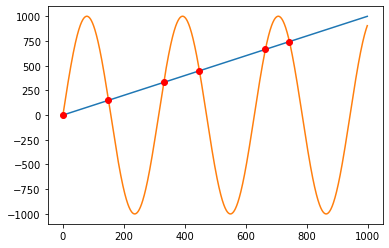

6

In [123]:
#Check how to get the no of intersections 
x = np.arange(0, 1000)
f = np.arange(0, 1000)
g = np.sin(np.arange(0, 10, 0.01) * 2) * 1000

plt.plot(x, f, '-')
plt.plot(x, g, '-')

idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
plt.plot(f[idx], f[idx], 'ro')
plt.show()
idx.shape[0]

### Using Original Basis (Linear + Periodic) 
By testing single or zero intersects by samples on mean function

In [124]:
#read data
data = pd.read_csv('https://gitlab.com/vsambhe1/machine-learning-competition/raw/master/train.csv')

Average Loss = 222.66: 100%|██████████| 60000/60000 [00:17<00:00, 3427.16it/s]
Finished [100%]: Average Loss = 222.66


[-4.78163054e-01  9.36525366e-01  1.58907366e-01  3.45249355e-01
 -8.28664490e-04  1.22456190e-01  6.43307929e-02  2.59641991e-01
  1.74800937e-01  1.19816290e-01  9.75111710e-02 -5.00531944e-02
 -8.19066815e-02  2.79660439e-01]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


0

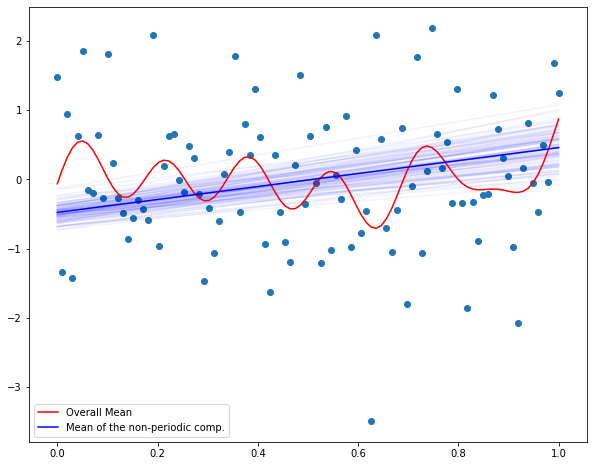

In [125]:
X = np.linspace(0,1,100)

Y = data.iloc[0,1:101].values
run_model(X,Y,0,plot=True) 

Classification of label was correct

### Testing All Basis Functions (Linear, Periodic & Non Linear)

(100, 15)


Average Loss = 228.6: 100%|██████████| 60000/60000 [00:16<00:00, 3690.85it/s] 
Finished [100%]: Average Loss = 228.61


all predictions
posterior_probability_deriviative_is_positive 0.0
0
Linear predictions
posterior_probability_deriviative_is_positive 1.0
1
Periodic predictions
posterior_probability_deriviative_is_positive 0.0
0
nonlinear predictions
posterior_probability_deriviative_is_positive 0.0
0


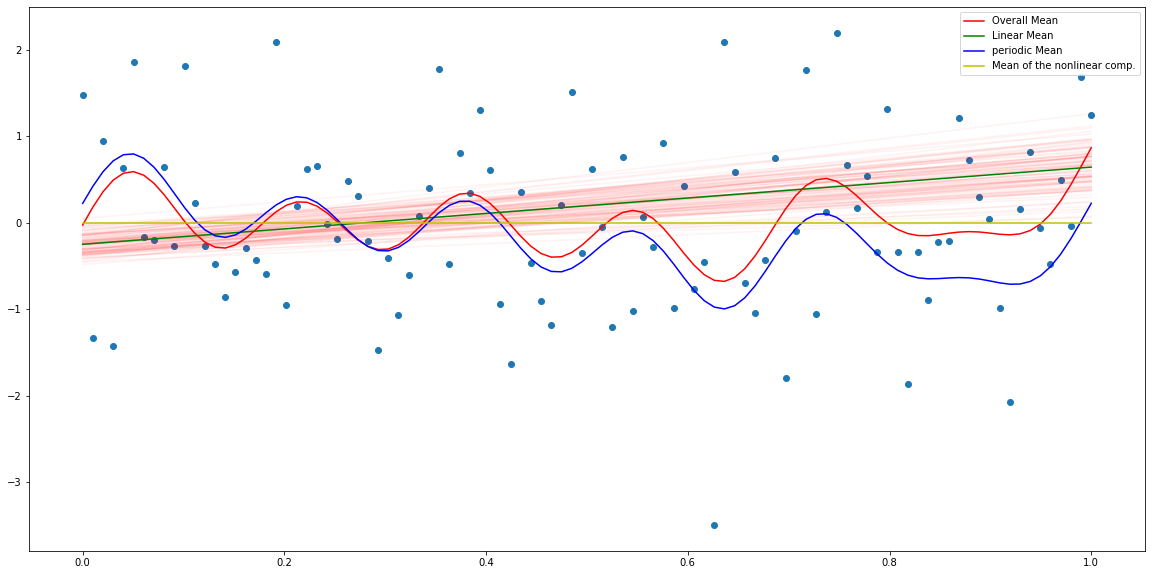

In [126]:
X = np.linspace(0,1,100)

Y = data.iloc[0,1:101].values
run_model1(X,Y,1,plot=True)  

## Using Make Basis on Second Model (Multiple Intercepts)

Average Loss = 222.67: 100%|██████████| 60000/60000 [00:16<00:00, 3729.90it/s]
Finished [100%]: Average Loss = 222.67


[-0.47446912  0.92078489  0.14312373  0.34395732 -0.00160693  0.11491962
  0.07757925  0.27764203  0.18070365  0.13315419  0.08443176 -0.05996083
 -0.10718307  0.28348527]
intersections 8
periodic - non linear to be used for gradient calculation
posterior_probability_deriviative_is_positive 1.0


1

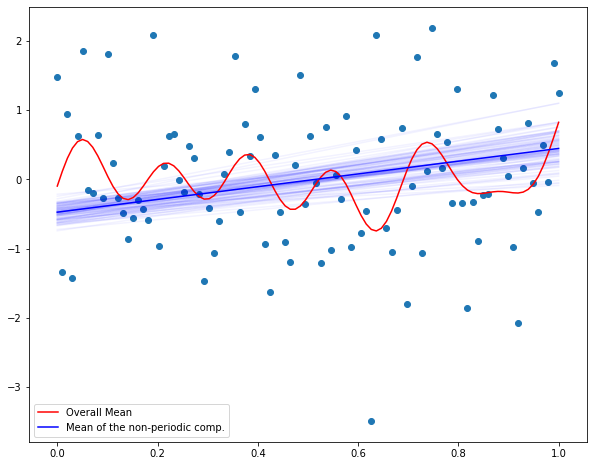

In [127]:
X = np.linspace(0,1,100)

Y = data.iloc[0,1:101].values
run_model2(X,Y,0,plot=True)   

Model 2 approach not working , above result is wrong

## Using Original Basis with Single Intercept

Average Loss = 193.72: 100%|██████████| 60000/60000 [00:16<00:00, 3538.91it/s]
Finished [100%]: Average Loss = 193.72


[-0.25444125  0.48381993  0.01838009 -0.52900515  0.09647515 -0.18597398
  0.67666952 -0.14934093 -0.03877814 -0.06432325  0.15335138 -0.10528513
  0.03508164 -0.07401481]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


0

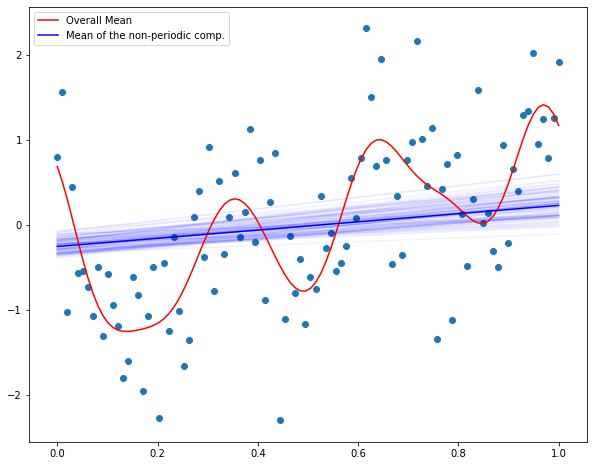

In [128]:
X = np.linspace(0,1,100)

Y = data.iloc[3,1:101].values
run_model(X,Y,0,plot=True) 

The result is correct above, lets try 4th and 15th

Average Loss = 166.81: 100%|██████████| 60000/60000 [00:16<00:00, 3598.70it/s]
Finished [100%]: Average Loss = 166.83


[-0.95590683  1.8984222   0.28160693 -0.3406313   0.04160465 -0.13839877
  0.06042475 -0.06368579 -0.00461153 -0.13135724 -0.11100545 -0.13856796
  0.10340317 -0.01450264]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


0

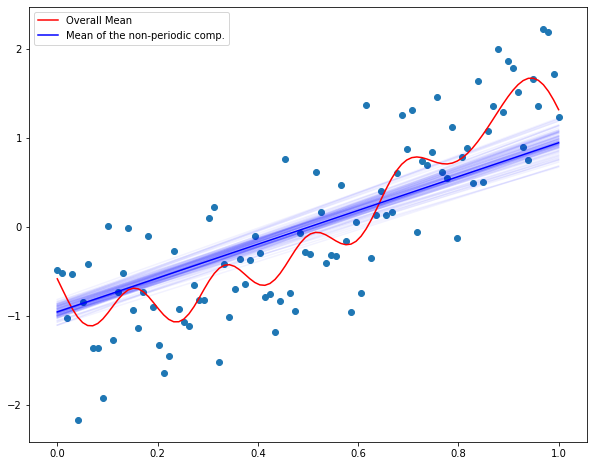

In [129]:
X = np.linspace(0,1,100)

Y = data.iloc[4,1:101].values
run_model(X,Y,0,plot=True) 

Average Loss = 124.99: 100%|██████████| 60000/60000 [00:16<00:00, 3548.97it/s]
Finished [100%]: Average Loss = 124.98


[-1.439165    2.85606969  0.34867334 -0.10066685 -0.16038101 -0.05381049
  0.0627602  -0.00821587 -0.02927495 -0.03382606  0.05007196  0.00496496
  0.03563703  0.02994078]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


0

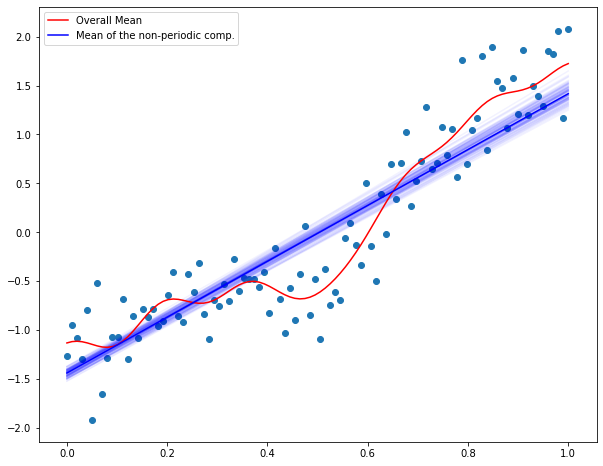

In [130]:
X = np.linspace(0,1,100)

Y = data.iloc[15,1:101].values
run_model(X,Y,0,plot=True) 

The classifications above are wrong

We wanted to run run_model1 code and run_model2 based on basis functions and submit the score, but it was taking very long so we switched to PyMC3 further to try gain some performance improvement in training the model. 

In [1]:
#The following peace of code is not run as it takes very long time. to commenting this code block.
#from google.colab import files
#test_df = pd.read_csv('https://gitlab.com/vsambhe1/machine-learning-competition/raw/master/test.csv')
#x = np.linspace(0,1,100)
#Decision = pd.DataFrame(columns=['Id','Category'])
# train_df.shape[0]
#for r in range(test_df.shape[0]):
#    id_row = test_df.iloc[r,0]
#    y = test_df.iloc[r,1:101].values
#    d = run_model(x,y,0,plot=True) 
#    
#    Decision = Decision.append({'Id': int(id_row), 'Category': int(d)}, ignore_index=True)
  
  
# output_file = Decision.to_csv('submission_1.csv')

	
#files.download(output_file)

In [ ]:
#The following peace of code is not run as it takes very long time. to commenting this code block.
#from google.colab import files

#x = np.linspace(0,1,100)
#Decision = pd.DataFrame(columns=['Id','Category'])
# train_df.shape[0]
#for r in range(test_df.shape[0]):
#    id_row = test_df.iloc[r,0]
#    y = test_df.iloc[r,1:101].values
#    d = run_model2(x,y,0,plot=True) 
    
#    Decision = Decision.append({'Id': int(id_row), 'Category': int(d)}, ignore_index=True)
  
  
# output_file = Decision.to_csv('submission_2.csv')

	
#files.download(output_file)


## PyMC3 - Gaussian Process
Here we will utilize PyMC3's Gaussian Process to detect and remove the seasonal component of each countries sales data if one is present.

### Applying PyMC3 model to train dataset

To start we will focus on one country (row) from the `train` dataset. We can now plot sales data for country which can give us a better understanding of a particular countries sales projection.

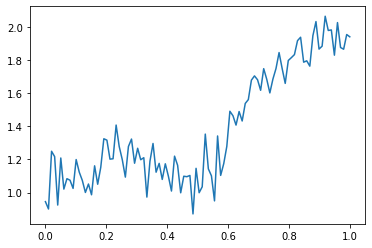

In [131]:
def get_single_row(df, row):
    '''
    Pull a singe row from the data (df).
    X is linearly space from 0 to 1.
    '''
    X = np.linspace(0, 1, 100)
    Y = df.iloc[row, 1:101].values
    X = X[:, None]
    Y = Y[:, None]
    return X, Y

X, Y = get_single_row(train_df, 18)
plt.plot(X,Y)
plt.show()

In [132]:
with pm.Model() as model:
    #  periodic component x 
    η_true  = pm.Normal("η_true", mu=0.1, sigma=3)
    ℓ_true  = pm.Normal("ℓ_true", mu=0.1, sigma=3)

    cov_seasonal = η_true**2 * pm.gp.cov.ExpQuad(1, ℓ_true) # Maybe change this to 100 since its 100 dimentions
    gp1 = pm.gp.Marginal(cov_func=cov_seasonal)

    #  linear component x 
    cov_linear = η_true**2 * pm.gp.cov.Matern32(1, ℓ_true) # Maybe change this to 100 since its 100 dimentions
    gp2 = pm.gp.Marginal(cov_func=cov_linear)

    # gp represents f1 + f2.
    gp = gp1 + gp2

    # noise model
    sigma = pm.HalfCauchy("sigma", beta=5, testval=0.1)
    f = gp.marginal_likelihood("f", X, Y[:,0], noise=sigma)

    # this line calls an optimizer to optimize the marginal likelihood
    mp = pm.find_MAP(include_transformed=True)

logp = 66.555, ||grad|| = 0.03297: 100%|██████████| 18/18 [00:00<00:00, 331.91it/s]  


In [133]:
#optimized parameters
sorted([name+":"+str(mp[name]) for name in mp.keys() if not name.endswith("_")])

['sigma:0.09646366589418796',
 'η_true:0.9217250135042945',
 'ℓ_true:0.783129994937172']

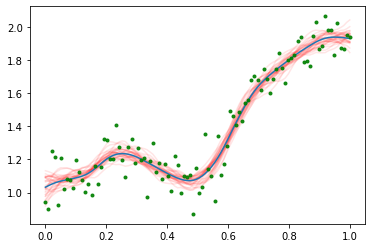

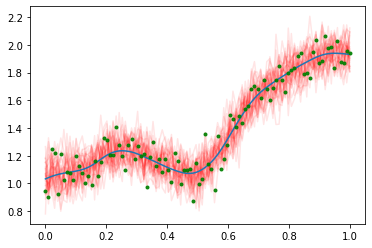

In [134]:
# 200 new values from x=0 to x=3
n_new = 100
X_new = np.linspace(0, 1, n_new)[:,None]

#periodic term
f1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma})
y1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma}, pred_noise=True)
#linear term
f2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma})
y2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma}, pred_noise=True)
#sum of periodic and linear term
y_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma}, pred_noise=True)
f_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": X, "y": Y[:,0], "noise": sigma})

#we sample 10 regression lines from the posterior
sample_f = multivariate_normal(f_pred[0],f_pred[1]).rvs(30)

plt.plot(X_new[:,0],sample_f.T,color='red',alpha=0.1)# regression lines
plt.plot(X_new[:,0],f_pred[0])# this is the average line
plt.plot(X, Y, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);
plt.show()

#we sample 10 regression lines from the posterior
sample_y = multivariate_normal(y_pred[0],y_pred[1]).rvs(30)

plt.plot(X_new[:,0],sample_y.T,color='red',alpha=0.1)# regression lines
plt.plot(X_new[:,0],f_pred[0])# this is the average line
plt.plot(X, Y, 'og', ms=3, alpha=0.9, label="Observed data", Zorder=1000);
plt.show()

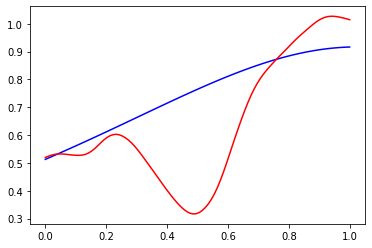

In [135]:
#we can recover the single components
plt.plot(X_new[:,0],f1_pred[0], color="blue")
plt.plot(X_new[:,0],f2_pred[0], color="red")
plt.show()

In [136]:
f2_pred[0]

array([0.51946469, 0.52392334, 0.52786946, 0.5305984 , 0.53195748,
       0.5322654 , 0.5316632 , 0.53053916, 0.52923668, 0.52807594,
       0.52732341, 0.52715397, 0.52802208, 0.53052087, 0.53512099,
       0.54194278, 0.55076178, 0.56093719, 0.57171043, 0.58202861,
       0.59079901, 0.59735818, 0.60143145, 0.60276904, 0.6011748 ,
       0.59694632, 0.59059285, 0.58245608, 0.57249989, 0.56078336,
       0.54762873, 0.53334316, 0.51835042, 0.50310973, 0.48798024,
       0.47277085, 0.45728032, 0.44165866, 0.42608674, 0.41077977,
       0.39586617, 0.38156849, 0.36804266, 0.35526444, 0.3435376 ,
       0.33340554, 0.32525785, 0.31950829, 0.31667294, 0.31723384,
       0.32119129, 0.32853167, 0.33900222, 0.35227466, 0.36862937,
       0.38849874, 0.41202221, 0.43877262, 0.46844223, 0.50038215,
       0.53356403, 0.56690758, 0.59975633, 0.63175629, 0.66258815,
       0.6919647 , 0.71946061, 0.7446406 , 0.76714602, 0.78692838,
       0.80427573, 0.81962756, 0.83338933, 0.84612299, 0.85833

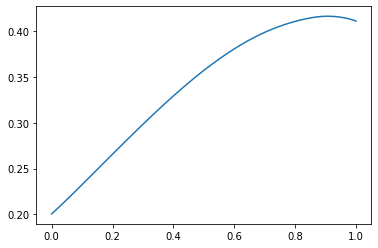

In [137]:
plt.plot(X_new[:,0],f2_pred[1][88])
plt.show()

### Applying PyMC3 model to test dataset

Defining `run_model_pymc` method that we will call in a loop for each row in the dataset.

In [138]:
def run_model_pymc(x_in, y_in, plot=False):
    with pm.Model() as model:
        #  periodic component x 
        η_true  = pm.Normal("η_true", mu=0.1, sigma=3)
        ℓ_true  = pm.Normal("ℓ_true", mu=0.1, sigma=3)

        cov_seasonal = η_true**2 * pm.gp.cov.ExpQuad(1, ℓ_true) # Maybe change this to 100 since its 100 dimentions
        gp1 = pm.gp.Marginal(cov_func=cov_seasonal)

        #  linear component x 
        cov_linear = η_true**2 * pm.gp.cov.Matern32(1, ℓ_true) # Maybe change this to 100 since its 100 dimentions
        gp2 = pm.gp.Marginal(cov_func=cov_linear)

        # gp represents f1 + f2.
        gp = gp1 + gp2

        # noise model
        sigma = pm.HalfCauchy("sigma", beta=5, testval=0.1)
        f = gp.marginal_likelihood("f", x_in, y_in[:,0], noise=sigma)

        # this line calls an optimizer to optimize the marginal likelihood
        mp = pm.find_MAP(include_transformed=True)

    # 200 new values from x=0 to x=3
    n_new = 100
    X_new = np.linspace(0, 1, n_new)[:,None]

    #periodic term
    f1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma})
    y1_pred = gp1.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma}, pred_noise=True)
    #linear term
    f2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma})
    y2_pred = gp2.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma}, pred_noise=True)
    #sum of periodic and linear term
    y_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma}, pred_noise=True)
    f_pred  = gp.predict(X_new, point=mp, given={"gp": gp, "X": x_in, "y": y_in[:,0], "noise": sigma})
    
    posterior_probability_deriviative_is_positive = len(np.where(np.gradient(f2_pred[0],X_new[:,0])>0)[0])/len(f2_pred[0])
    
    print("Probability Sales Increasing is: ", posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.8:
        return 1
    else:
        return 0

Here we define the x space as linearly distributed between 0 and 1 for 100 points. We then loop over each row in our test dataset and run the model defined above on the data.

#### Kernel Choice
For this model we chose ExpQuad and Matern. ExpQuad was chosen to model the seasonal trend and Matern the long term trend. 

We joined them as additive kernels since we deduced that the overall trend was combination of seasonal plus long term trend. As we discovered earlier in the notebook, seasonality may not affect every country in the dataset. Therefor the choice here should favor whichever trend is stronger. 

By performing the prediction on Matern we are favoring the long term trend in the data.

In [139]:
def make_decision(dataset, run_model, num_rows=0):
    '''
        Method to execute decision loop.
        dataset: data to iterate
        run_model: method that runs model on x and y data
        num_rows: this can be used to only target a specific number of rows. If 0 then the full dataset is used.
    '''
    num_rows = dataset.shape[0] if num_rows == 0 else num_rows
    x = np.linspace(0,1,100)[:,None]
    Decision = pd.DataFrame(columns=['Id','Category'])
    
    for r in range(num_rows):
        id_row = dataset.iloc[r, 0]
        y = dataset.iloc[r, 1:101].values[:,None]
        decision = run_model(x, y)
        Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True)
        print(f'{r + 1}/{num_rows} rows complete')
        
    return Decision

In [140]:
Decision = make_decision(test_df, run_model_pymc)
Decision.to_csv('submission_pymc3.csv')

logp = 70.088, ||grad|| = 0.016035: 100%|██████████| 25/25 [00:00<00:00, 546.61it/s]  


Probability Sales Increasing is:  1.0
1/120 rows complete


logp = 79.029, ||grad|| = 0.27356: 100%|██████████| 15/15 [00:00<00:00, 545.97it/s]  


Probability Sales Increasing is:  0.75
2/120 rows complete


logp = 81.088, ||grad|| = 12.25: 100%|██████████| 21/21 [00:00<00:00, 559.32it/s]  


Probability Sales Increasing is:  0.6
3/120 rows complete


logp = 83.11, ||grad|| = 4.6177: 100%|██████████| 29/29 [00:00<00:00, 531.13it/s]   


Probability Sales Increasing is:  0.51
4/120 rows complete


logp = 64.607, ||grad|| = 0.40017: 100%|██████████| 20/20 [00:00<00:00, 528.53it/s]  


Probability Sales Increasing is:  0.75
5/120 rows complete


logp = 66.709, ||grad|| = 11.903: 100%|██████████| 19/19 [00:00<00:00, 482.76it/s]  


Probability Sales Increasing is:  0.57
6/120 rows complete


logp = 72.839, ||grad|| = 0.48624: 100%|██████████| 17/17 [00:00<00:00, 490.41it/s]  


Probability Sales Increasing is:  0.8
7/120 rows complete


logp = 81.506, ||grad|| = 0.19752: 100%|██████████| 26/26 [00:00<00:00, 471.03it/s]  


Probability Sales Increasing is:  0.98
8/120 rows complete


logp = 75.192, ||grad|| = 0.00093609: 100%|██████████| 13/13 [00:00<00:00, 470.52it/s]  


Probability Sales Increasing is:  0.47
9/120 rows complete


logp = 54.998, ||grad|| = 1.2991: 100%|██████████| 27/27 [00:00<00:00, 462.34it/s]  


Probability Sales Increasing is:  0.62
10/120 rows complete


logp = 67.529, ||grad|| = 0.55685: 100%|██████████| 21/21 [00:00<00:00, 513.93it/s]  


Probability Sales Increasing is:  0.82
11/120 rows complete


logp = 70.225, ||grad|| = 0.12948: 100%|██████████| 18/18 [00:00<00:00, 521.48it/s]  


Probability Sales Increasing is:  1.0
12/120 rows complete


logp = 60.997, ||grad|| = 14.08: 100%|██████████| 20/20 [00:00<00:00, 430.68it/s]  


Probability Sales Increasing is:  0.53
13/120 rows complete


logp = 78.106, ||grad|| = 5.5721: 100%|██████████| 16/16 [00:00<00:00, 456.49it/s]  


Probability Sales Increasing is:  0.43
14/120 rows complete


logp = 66.433, ||grad|| = 0.0013202: 100%|██████████| 22/22 [00:00<00:00, 493.96it/s]  


Probability Sales Increasing is:  0.46
15/120 rows complete


logp = 83.522, ||grad|| = 1.3617: 100%|██████████| 29/29 [00:00<00:00, 480.43it/s]  


Probability Sales Increasing is:  0.95
16/120 rows complete


logp = 57.858, ||grad|| = 0.84049: 100%|██████████| 19/19 [00:00<00:00, 332.83it/s]  


Probability Sales Increasing is:  0.77
17/120 rows complete


logp = 68.784, ||grad|| = 0.0049116: 100%|██████████| 13/13 [00:00<00:00, 356.78it/s]  


Probability Sales Increasing is:  0.57
18/120 rows complete


logp = 73.61, ||grad|| = 0.20097: 100%|██████████| 14/14 [00:00<00:00, 476.48it/s]  


Probability Sales Increasing is:  0.52
19/120 rows complete


logp = 71.665, ||grad|| = 0.044518: 100%|██████████| 19/19 [00:00<00:00, 479.54it/s]  


Probability Sales Increasing is:  1.0
20/120 rows complete


logp = 71.057, ||grad|| = 5.9456e-05: 100%|██████████| 22/22 [00:00<00:00, 449.21it/s]  


Probability Sales Increasing is:  0.62
21/120 rows complete


logp = 67.511, ||grad|| = 30.582: 100%|██████████| 27/27 [00:00<00:00, 399.73it/s]  


Probability Sales Increasing is:  0.49
22/120 rows complete


logp = 77.291, ||grad|| = 26.935: 100%|██████████| 21/21 [00:00<00:00, 401.76it/s]  


Probability Sales Increasing is:  0.5
23/120 rows complete


logp = 61.696, ||grad|| = 0.00076236: 100%|██████████| 13/13 [00:00<00:00, 418.98it/s]  


Probability Sales Increasing is:  0.53
24/120 rows complete


logp = 66.086, ||grad|| = 0.007008: 100%|██████████| 13/13 [00:00<00:00, 478.94it/s]  


Probability Sales Increasing is:  0.49
25/120 rows complete


logp = 93.475, ||grad|| = 0.16638: 100%|██████████| 26/26 [00:00<00:00, 450.60it/s]  


Probability Sales Increasing is:  0.27
26/120 rows complete


logp = 64.687, ||grad|| = 0.012814: 100%|██████████| 13/13 [00:00<00:00, 498.50it/s]  


Probability Sales Increasing is:  0.52
27/120 rows complete


logp = 75.343, ||grad|| = 0.00044095: 100%|██████████| 22/22 [00:00<00:00, 483.38it/s]  


Probability Sales Increasing is:  0.88
28/120 rows complete


logp = 64.599, ||grad|| = 10.081: 100%|██████████| 20/20 [00:00<00:00, 419.58it/s]  


Probability Sales Increasing is:  0.53
29/120 rows complete


logp = 61.776, ||grad|| = 0.0058629: 100%|██████████| 24/24 [00:00<00:00, 445.89it/s]  


Probability Sales Increasing is:  1.0
30/120 rows complete


logp = 76.66, ||grad|| = 0.11049: 100%|██████████| 26/26 [00:00<00:00, 376.39it/s]  


Probability Sales Increasing is:  1.0
31/120 rows complete


logp = 73.407, ||grad|| = 0.096611: 100%|██████████| 18/18 [00:00<00:00, 368.43it/s]  


Probability Sales Increasing is:  0.91
32/120 rows complete


logp = 71.835, ||grad|| = 0.29674: 100%|██████████| 26/26 [00:00<00:00, 420.53it/s]  


Probability Sales Increasing is:  1.0
33/120 rows complete


logp = 61.755, ||grad|| = 0.016704: 100%|██████████| 26/26 [00:00<00:00, 479.30it/s]  


Probability Sales Increasing is:  1.0
34/120 rows complete


logp = 66.365, ||grad|| = 0.29754: 100%|██████████| 19/19 [00:00<00:00, 373.08it/s]  


Probability Sales Increasing is:  0.76
35/120 rows complete


logp = 58.664, ||grad|| = 0.019916: 100%|██████████| 25/25 [00:00<00:00, 482.84it/s]  


Probability Sales Increasing is:  1.0
36/120 rows complete


logp = 60.274, ||grad|| = 0.65628: 100%|██████████| 21/21 [00:00<00:00, 483.58it/s]  


Probability Sales Increasing is:  0.72
37/120 rows complete


logp = 76.007, ||grad|| = 0.0031595: 100%|██████████| 13/13 [00:00<00:00, 461.02it/s]  


Probability Sales Increasing is:  0.47
38/120 rows complete


logp = 70.802, ||grad|| = 0.44748: 100%|██████████| 19/19 [00:00<00:00, 505.70it/s]  


Probability Sales Increasing is:  0.7
39/120 rows complete


logp = 80.273, ||grad|| = 5.271: 100%|██████████| 18/18 [00:00<00:00, 507.31it/s]  


Probability Sales Increasing is:  0.65
40/120 rows complete


logp = 76.215, ||grad|| = 0.062981: 100%|██████████| 26/26 [00:00<00:00, 500.69it/s]  


Probability Sales Increasing is:  1.0
41/120 rows complete


logp = 80.982, ||grad|| = 0.28967: 100%|██████████| 26/26 [00:00<00:00, 483.53it/s]  


Probability Sales Increasing is:  0.78
42/120 rows complete


logp = 82.092, ||grad|| = 0.072551: 100%|██████████| 14/14 [00:00<00:00, 447.32it/s]  


Probability Sales Increasing is:  0.68
43/120 rows complete


logp = 79.489, ||grad|| = 0.016691: 100%|██████████| 13/13 [00:00<00:00, 455.17it/s]  


Probability Sales Increasing is:  0.58
44/120 rows complete


logp = 49.984, ||grad|| = 12.861: 100%|██████████| 21/21 [00:00<00:00, 456.02it/s]  


Probability Sales Increasing is:  0.5
45/120 rows complete


logp = 71.447, ||grad|| = 0.40535: 100%|██████████| 20/20 [00:00<00:00, 515.66it/s]  


Probability Sales Increasing is:  0.7
46/120 rows complete


logp = 65.273, ||grad|| = 0.0037152: 100%|██████████| 13/13 [00:00<00:00, 236.40it/s]  


Probability Sales Increasing is:  0.55
47/120 rows complete


logp = 77.895, ||grad|| = 1.7172: 100%|██████████| 21/21 [00:00<00:00, 546.07it/s]  


Probability Sales Increasing is:  0.78
48/120 rows complete


logp = 71.828, ||grad|| = 3.1284: 100%|██████████| 20/20 [00:00<00:00, 581.18it/s]  


Probability Sales Increasing is:  0.68
49/120 rows complete


logp = 67.24, ||grad|| = 1.0663: 100%|██████████| 19/19 [00:00<00:00, 591.90it/s]  


Probability Sales Increasing is:  0.84
50/120 rows complete


logp = 57.775, ||grad|| = 5.1411: 100%|██████████| 28/28 [00:00<00:00, 606.18it/s]  


Probability Sales Increasing is:  0.64
51/120 rows complete


logp = 60.677, ||grad|| = 0.0091052: 100%|██████████| 24/24 [00:00<00:00, 576.38it/s]  


Probability Sales Increasing is:  0.79
52/120 rows complete


logp = 72.821, ||grad|| = 0.089286: 100%|██████████| 15/15 [00:00<00:00, 588.60it/s]  


Probability Sales Increasing is:  0.76
53/120 rows complete


logp = 90.833, ||grad|| = 0.0009267: 100%|██████████| 22/22 [00:00<00:00, 592.66it/s]  


Probability Sales Increasing is:  1.0
54/120 rows complete


logp = 43.798, ||grad|| = 0.081703: 100%|██████████| 25/25 [00:00<00:00, 588.57it/s]  


Probability Sales Increasing is:  0.58
55/120 rows complete


logp = 86.218, ||grad|| = 0.065569: 100%|██████████| 14/14 [00:00<00:00, 528.44it/s]  


Probability Sales Increasing is:  0.47
56/120 rows complete


logp = 63.837, ||grad|| = 0.012047: 100%|██████████| 13/13 [00:00<00:00, 588.45it/s]  


Probability Sales Increasing is:  0.59
57/120 rows complete


logp = 66.903, ||grad|| = 0.25004: 100%|██████████| 16/16 [00:00<00:00, 530.84it/s]  


Probability Sales Increasing is:  0.47
58/120 rows complete


logp = 69.196, ||grad|| = 0.80881: 100%|██████████| 21/21 [00:00<00:00, 583.11it/s]  


Probability Sales Increasing is:  0.7
59/120 rows complete


logp = 65.894, ||grad|| = 0.27202: 100%|██████████| 20/20 [00:00<00:00, 616.81it/s]  


Probability Sales Increasing is:  0.72
60/120 rows complete


logp = 72.459, ||grad|| = 0.56107: 100%|██████████| 19/19 [00:00<00:00, 577.49it/s]  


Probability Sales Increasing is:  1.0
61/120 rows complete


logp = 51.066, ||grad|| = 0.0044444: 100%|██████████| 23/23 [00:00<00:00, 584.48it/s]  


Probability Sales Increasing is:  0.57
62/120 rows complete


logp = 67.254, ||grad|| = 0.23029: 100%|██████████| 16/16 [00:00<00:00, 489.87it/s]  


Probability Sales Increasing is:  0.54
63/120 rows complete


logp = 88, ||grad|| = 10.549: 100%|██████████| 31/31 [00:00<00:00, 600.22it/s]      


Probability Sales Increasing is:  0.97
64/120 rows complete


logp = 82.921, ||grad|| = 0.10402: 100%|██████████| 24/24 [00:00<00:00, 584.11it/s]  


Probability Sales Increasing is:  0.94
65/120 rows complete


logp = 57.162, ||grad|| = 0.021661: 100%|██████████| 24/24 [00:00<00:00, 285.97it/s]  


Probability Sales Increasing is:  0.57
66/120 rows complete


logp = 71.958, ||grad|| = 0.15978: 100%|██████████| 15/15 [00:00<00:00, 466.33it/s]  


Probability Sales Increasing is:  0.69
67/120 rows complete


logp = 57.116, ||grad|| = 1.9725: 100%|██████████| 18/18 [00:00<00:00, 469.13it/s]  


Probability Sales Increasing is:  0.61
68/120 rows complete


logp = 77.571, ||grad|| = 0.12383: 100%|██████████| 24/24 [00:00<00:00, 468.72it/s]  


Probability Sales Increasing is:  0.46
69/120 rows complete


logp = 61.966, ||grad|| = 0.62011: 100%|██████████| 20/20 [00:00<00:00, 449.14it/s]  


Probability Sales Increasing is:  0.69
70/120 rows complete


logp = 61.73, ||grad|| = 0.50891: 100%|██████████| 21/21 [00:00<00:00, 490.13it/s]  


Probability Sales Increasing is:  0.72
71/120 rows complete


logp = 73.5, ||grad|| = 0.091234: 100%|██████████| 27/27 [00:00<00:00, 434.97it/s]  


Probability Sales Increasing is:  0.87
72/120 rows complete


logp = 77.879, ||grad|| = 2.584: 100%|██████████| 30/30 [00:00<00:00, 482.90it/s]   


Probability Sales Increasing is:  0.31
73/120 rows complete


logp = 72.483, ||grad|| = 0.42485: 100%|██████████| 15/15 [00:00<00:00, 457.71it/s]  


Probability Sales Increasing is:  0.6
74/120 rows complete


logp = 77.718, ||grad|| = 3.1721: 100%|██████████| 21/21 [00:00<00:00, 497.69it/s]  


Probability Sales Increasing is:  0.56
75/120 rows complete


logp = 55.194, ||grad|| = 7.1715: 100%|██████████| 19/19 [00:00<00:00, 475.41it/s]  


Probability Sales Increasing is:  0.6
76/120 rows complete


logp = 59.172, ||grad|| = 0.11636: 100%|██████████| 20/20 [00:00<00:00, 470.84it/s]  


Probability Sales Increasing is:  0.7
77/120 rows complete


logp = 77.381, ||grad|| = 21.464: 100%|██████████| 19/19 [00:00<00:00, 461.38it/s]  


Probability Sales Increasing is:  0.52
78/120 rows complete


logp = 82.305, ||grad|| = 1.2624: 100%|██████████| 20/20 [00:00<00:00, 447.27it/s]  


Probability Sales Increasing is:  0.76
79/120 rows complete


logp = 65.947, ||grad|| = 0.12327: 100%|██████████| 15/15 [00:00<00:00, 424.42it/s]  


Probability Sales Increasing is:  0.61
80/120 rows complete


logp = 54.116, ||grad|| = 16.154: 100%|██████████| 20/20 [00:00<00:00, 391.56it/s]  


Probability Sales Increasing is:  0.51
81/120 rows complete


logp = 63.845, ||grad|| = 0.00088728: 100%|██████████| 22/22 [00:00<00:00, 481.58it/s]  


Probability Sales Increasing is:  0.8
82/120 rows complete


logp = 73.29, ||grad|| = 0.12412: 100%|██████████| 25/25 [00:00<00:00, 449.89it/s]  


Probability Sales Increasing is:  1.0
83/120 rows complete


logp = 43.673, ||grad|| = 0.95655: 100%|██████████| 26/26 [00:00<00:00, 433.99it/s]  


Probability Sales Increasing is:  0.55
84/120 rows complete


logp = 82.668, ||grad|| = 20.685: 100%|██████████| 17/17 [00:00<00:00, 373.23it/s]  


Probability Sales Increasing is:  0.52
85/120 rows complete


logp = 76.087, ||grad|| = 19.73: 100%|██████████| 18/18 [00:00<00:00, 378.83it/s]  


Probability Sales Increasing is:  0.44
86/120 rows complete


logp = 83.789, ||grad|| = 0.68673: 100%|██████████| 27/27 [00:00<00:00, 318.22it/s]  


Probability Sales Increasing is:  0.79
87/120 rows complete


logp = 75.834, ||grad|| = 0.00056672: 100%|██████████| 22/22 [00:00<00:00, 442.63it/s]  


Probability Sales Increasing is:  0.5
88/120 rows complete


logp = 61.697, ||grad|| = 0.00020881: 100%|██████████| 22/22 [00:00<00:00, 470.42it/s]  


Probability Sales Increasing is:  0.78
89/120 rows complete


logp = 42.189, ||grad|| = 4.2626: 100%|██████████| 27/27 [00:00<00:00, 460.72it/s]  


Probability Sales Increasing is:  0.53
90/120 rows complete


logp = 89.097, ||grad|| = 0.017121: 100%|██████████| 22/22 [00:00<00:00, 379.36it/s]  


Probability Sales Increasing is:  0.31
91/120 rows complete


logp = 76.396, ||grad|| = 0.060103: 100%|██████████| 19/19 [00:00<00:00, 517.66it/s]  


Probability Sales Increasing is:  1.0
92/120 rows complete


logp = 70.201, ||grad|| = 1.0297: 100%|██████████| 25/25 [00:00<00:00, 443.84it/s]  


Probability Sales Increasing is:  0.72
93/120 rows complete


logp = 91.505, ||grad|| = 0.20968: 100%|██████████| 19/19 [00:00<00:00, 431.38it/s]  


Probability Sales Increasing is:  0.81
94/120 rows complete


logp = 73.457, ||grad|| = 0.10563: 100%|██████████| 25/25 [00:00<00:00, 488.44it/s]  


Probability Sales Increasing is:  0.84
95/120 rows complete


logp = 70.798, ||grad|| = 2.5678: 100%|██████████| 18/18 [00:00<00:00, 332.95it/s]  


Probability Sales Increasing is:  0.54
96/120 rows complete


logp = 76.361, ||grad|| = 0.041442: 100%|██████████| 16/16 [00:00<00:00, 498.78it/s]  


Probability Sales Increasing is:  0.59
97/120 rows complete


logp = 66.162, ||grad|| = 1.1911: 100%|██████████| 26/26 [00:00<00:00, 480.63it/s]  


Probability Sales Increasing is:  0.6
98/120 rows complete


logp = 84.094, ||grad|| = 2.2893: 100%|██████████| 18/18 [00:00<00:00, 423.80it/s]  


Probability Sales Increasing is:  0.79
99/120 rows complete


logp = 77.635, ||grad|| = 0.0006582: 100%|██████████| 24/24 [00:00<00:00, 474.93it/s]  


Probability Sales Increasing is:  1.0
100/120 rows complete


logp = 54.595, ||grad|| = 19.709: 100%|██████████| 21/21 [00:00<00:00, 425.17it/s]  


Probability Sales Increasing is:  0.54
101/120 rows complete


logp = 66.155, ||grad|| = 0.013395: 100%|██████████| 13/13 [00:00<00:00, 432.88it/s]  


Probability Sales Increasing is:  0.47
102/120 rows complete


logp = 41.19, ||grad|| = 2.8222: 100%|██████████| 27/27 [00:00<00:00, 444.50it/s]   


Probability Sales Increasing is:  0.57
103/120 rows complete


logp = 71.588, ||grad|| = 2.4096: 100%|██████████| 21/21 [00:00<00:00, 507.45it/s]  


Probability Sales Increasing is:  0.72
104/120 rows complete


logp = 67.351, ||grad|| = 0.62094: 100%|██████████| 19/19 [00:00<00:00, 460.28it/s]  


Probability Sales Increasing is:  1.0
105/120 rows complete


logp = 79.647, ||grad|| = 5.6958: 100%|██████████| 19/19 [00:00<00:00, 537.09it/s]  


Probability Sales Increasing is:  0.63
106/120 rows complete


logp = 58.037, ||grad|| = 0.16131: 100%|██████████| 21/21 [00:00<00:00, 331.05it/s]  


Probability Sales Increasing is:  0.54
107/120 rows complete


logp = 60.002, ||grad|| = 1.2792: 100%|██████████| 20/20 [00:00<00:00, 490.82it/s]  


Probability Sales Increasing is:  0.77
108/120 rows complete


logp = 74.502, ||grad|| = 0.46038: 100%|██████████| 27/27 [00:00<00:00, 426.66it/s]  


Probability Sales Increasing is:  0.63
109/120 rows complete


logp = 68.563, ||grad|| = 5.6549e-05: 100%|██████████| 22/22 [00:00<00:00, 393.22it/s]  


Probability Sales Increasing is:  0.52
110/120 rows complete


logp = 82.167, ||grad|| = 0.024795: 100%|██████████| 25/25 [00:00<00:00, 372.21it/s]  


Probability Sales Increasing is:  1.0
111/120 rows complete


logp = 66.822, ||grad|| = 0.48575: 100%|██████████| 24/24 [00:00<00:00, 294.02it/s]  


Probability Sales Increasing is:  1.0
112/120 rows complete


logp = 53.212, ||grad|| = 0.049819: 100%|██████████| 25/25 [00:00<00:00, 427.55it/s]  


Probability Sales Increasing is:  0.57
113/120 rows complete


logp = 51.873, ||grad|| = 0.058572: 100%|██████████| 19/19 [00:00<00:00, 448.47it/s]  


Probability Sales Increasing is:  0.66
114/120 rows complete


logp = 72.595, ||grad|| = 0.0028595: 100%|██████████| 23/23 [00:00<00:00, 416.70it/s]  


Probability Sales Increasing is:  0.81
115/120 rows complete


logp = 80.444, ||grad|| = 3.6374: 100%|██████████| 29/29 [00:00<00:00, 466.01it/s]  


Probability Sales Increasing is:  1.0
116/120 rows complete


logp = 74.49, ||grad|| = 0.53124: 100%|██████████| 21/21 [00:00<00:00, 314.41it/s]  


Probability Sales Increasing is:  0.68
117/120 rows complete


logp = 74.773, ||grad|| = 0.00090703: 100%|██████████| 23/23 [00:00<00:00, 356.04it/s]  


Probability Sales Increasing is:  1.0
118/120 rows complete


logp = 60.147, ||grad|| = 0.0051496: 100%|██████████| 13/13 [00:00<00:00, 410.19it/s]  


Probability Sales Increasing is:  0.55
119/120 rows complete


logp = 58.596, ||grad|| = 0.88226: 100%|██████████| 21/21 [00:00<00:00, 360.61it/s]  


Probability Sales Increasing is:  0.81
120/120 rows complete


## GPy

Here we move away from PyMC3 and use another PML package called GPy. We compare how both performed on the Sales data.

## Modeling the Trend
Now that we have methods for identifying a trend in the data we will attempt to model it. Earlier in this notebook we looked at extracting the trend using seasonal_decompose. We look again at the output trend. 

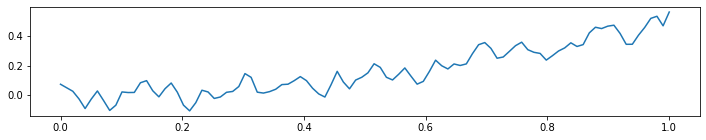

In [25]:
X = np.linspace(0,1,100)[:, None]
Y = decomp_single.trend[:, None]
plt.figure(figsize=(12, 2))
plt.plot(X,Y)

The trend data shown over a standardized [0,1] space

In [26]:
def model_kernel():
    '''
    Helper function that will allow the same kernel to be used elsewhere
    '''
    
    ker1 = GPy.kern.Matern52(1)
    ker2 = GPy.kern.ExpQuad(1)
    ker3 = GPy.kern.Linear(1)
    
    kernel = ker1*ker3
    return kernel

This method served as a bit of a focal point for efforts. The goal here was to model the data by way of one or more covariance functions (kernels). Each kernel has different properties that fit to different patterns. 

TODO: This section is important. Try to bring it together from others notebooks. 

GP_regression.,value,constraints,priors
mul.Mat52.variance,0.5987040604279988,+ve,
mul.Mat52.lengthscale,1.8744658286218647,+ve,
mul.linear.variances,0.5307607347858636,+ve,
Gaussian_noise.variance,0.0028773423535076387,+ve,


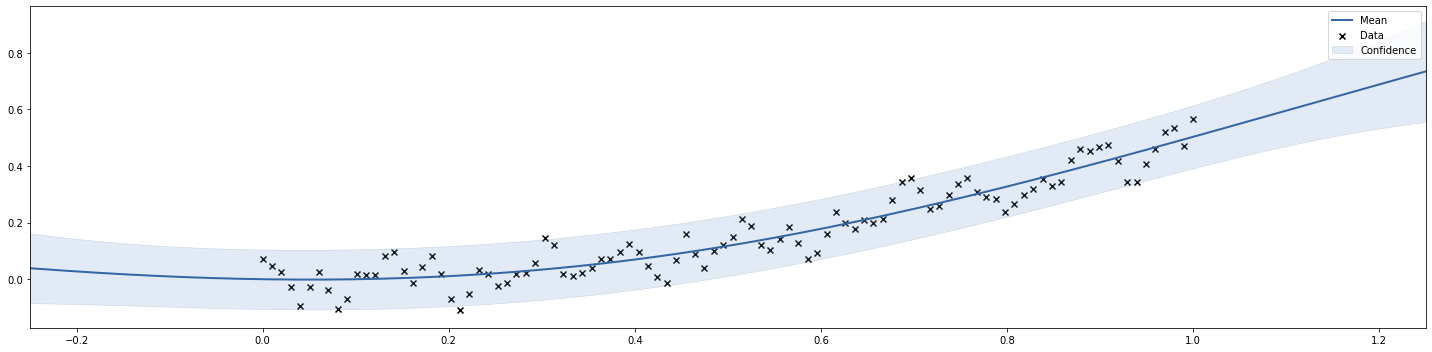

In [28]:
# Create our model and optomize the parameters
kernel = model_kernel()
s_model = GPy.models.GPRegression(X,Y,kernel=kernel)
s_model.optimize_restarts(20, robust=True, verbose=False, parallel=True, num_processes=12)

# Plot the results
fig = s_model.plot(figsize=(20,5))
display(s_model)

## GPy Model Output
Here we can see the output from our generated model. The points are the observed data that we passed in, an evenly spaces series of values between 0 & 1. The line is the mean value of the data and the shaded area is our confidence level.

An interesting aspect is how the area widens the further away we get from the observed points. 

TODO: More to fill in as to explaination  

## Training
Using a number of single examples we attempted to model the data. With that in place we started training against the test set, verifying our results against the labels provided to us. 

In [29]:
def run_model(x_in, y_in):
    '''
    Will run a model using the kernel defined earlier. Sampling will then allow us to 
    calculate the posterior probability that the sales trend is increasing for the given country
    '''

    kernel = model_kernel()
    model = GPy.models.GPRegression(x_in,y_in,kernel=kernel)
    model.optimize_restarts(20, robust=True, verbose=False, parallel=True, num_processes=12)
    
    # Generate a new set of X values, evenly spaced between 0,1
    x_new = X = np.linspace(0,1,100).reshape(-1,1)
    
    # Get the posterior distribution and sample
    f_pred, sigm_pred = model.predict_noiseless(x_new, full_cov=True, kern=kernel)
    Z = np.random.multivariate_normal(f_pred.T[0], sigm_pred, 1000).T
    
    posterior_der_pos = (np.diff(np.mean(Z.T,axis=0), 1)>0).sum()/len(np.mean(Z.T,axis=0))
    
    if posterior_der_pos>0.95:
        return 1
    else:
        return 0

## Training Data
Before applying our model to unseen data, we train and validate against known training data with set labels

In [32]:
num_rows = 5
actual = train_df.iloc[0:num_rows, -1]
predicted = []
x_d = np.linspace(0,1,100)[:, None]
for x in range(num_rows):
    print(f'Iteration: {x+1} of {num_rows}')
    decomp = seasonal_decompose(train_df.iloc[x,1:101].T, model='additive', freq=periodic_freq, extrapolate_trend='freq')
    y_d = decomp.trend.values[:, None]
    decision = run_model(x_d,y_d)
    predicted.append(decision)

Iteration: 1 of 5
Iteration: 2 of 5
Iteration: 3 of 5
Iteration: 4 of 5
Iteration: 5 of 5


## Results
Training complete we can now review our accuracy to determine how well our model performed

In [33]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

print(predicted)
results = confusion_matrix(actual, predicted) 
print(results)
print(f'Accuracy Score: {accuracy_score(actual, predicted)}')
print('The Report:')
print(classification_report(actual, predicted))

[0, 0, 0, 0, 0]
[[3 0]
 [2 0]]
Accuracy Score: 0.6
The Report:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.00      0.00      0.00         2

    accuracy                           0.60         5
   macro avg       0.30      0.50      0.37         5
weighted avg       0.36      0.60      0.45         5



## Unseen
Once we are happy with the performance of our model we can use it against the unseen dataset. This is a true measure of how well we have modeled our data.

In [34]:
allow_test = False
if allow_test:
    test_df = pd.read_csv("./data/test.csv")
    rows = test_df.shape[0]
    x_t = np.linspace(0,1,100)[:, None]
    
    Decision = pd.DataFrame(columns=['Id','Category'])
    for r in range(rows):
        print(f'Iteration: {r+1} of {rows}')
        id_row = test_df.iloc[r,0]
        decomp_t = seasonal_decompose(test_df.iloc[x,1:101].T, model='additive', freq=2, extrapolate_trend='freq')
        y_t = decomp_t.trend.values[:, None]
        decision = run_model(x_t,y_t)
        print(f'Decision is {decision} for Id {id_row}')
        Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 

    Decision.to_csv('submission.csv', index=False)

# For Discussion
Is any of this relevant or does it show more confusion than understanding

# Kernel Experimentation Notes
* Test 1 - Used RBF & Matern32
 * Definitely don't use RBF as selected kernel
 * Removing linespace=100 improved the accuracy to 0.6 selecting Matern32
* Test 2 - Used RBF & Poly order = 3. Selected Poly
 * Worse - dropped to 0.5
* Test 3 - Used RBF & PeriodicExponential. Selected PeriodicExponential
 * Improved to 0.75
 * Increased to predict against 30 countries from 20 - Reduced to 73
 * Increased to predict against 50 countries from 30 - Reduced to 68
 * Increased optimize restarts from 5 to 10 - No change still 66
* Test 4 - RBF, PeriodicExponential, White
 * Had zero effect - probably because white looks like a zero based function
* Test 5 - ExpQuad, PeriodicExponential, Matern52. Selected ExpQuad
 * Typical 60% accuracy
* Test 6 - RBF, PeriodicExponential, Poly
 * Typical 60%
* Test 7 - ExpQuad, PeriodicMatern52, Linear, Poly
 * Thinking here was that a linear function may help identify the trend without the noise affecting it
 * Not sure exactly why I'm thinking this
 * didn't work, promising at smaller numbers of samples, got worse as I increased number of countries

---

### GPy - Is this Suarabh's Attempt?

n this model, we tried to use GPY as we were getting LinAlg errors while using PMYC3.

We tried to mix the Matern32 and RBF kernel in this case, as Matern32 can be used for long term trend prediction 
and RBF can fit in the actual data, so if RBF is able to predict the points, then Matern32 can pick the non seasonal trend.

We used Matern32 for prediction to capture the non seasonal trend